<a href="https://colab.research.google.com/github/Keltings/Soccer/blob/main/DSA8203_CAT_I_LKelida_ID_169589.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Exploratory Data Analysis on ACLED Conflict Data for Liberia

## Introduction

In this Colab Notebook, I'll be conducting an Exploratory Data Analysis (EDA) on the ACLED Conflict Data for Liberia. The dataset provides detailed information on various conflict events, including actors, event types, and geographic locations.

The primary objectives of this analysis include:

1. **Checking for Missing Values:**
   - Identifying any columns with missing data and deciding on appropriate handling strategies.

2. **Checking for Duplicates:**
   - Detecting and handling any duplicate rows in the dataset.

3. **Checking Data Types:**
   - Verifying the data types of each column to ensure they align with our expectations.

4. **Checking Outliers:**
   - Visualizing box plots to identify potential outliers in numerical columns.

5. **Summary Statistics:**
   - Generating descriptive statistics to gain insights into the overall distribution of numerical and object columns.



In [54]:
#import packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources (run this only once)
nltk.download('punkt')
nltk.download('stopwords')


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


1. Load Data

In [47]:
#Import dataset
df = pd.read_csv('https://query.data.world/s/aivmkfgf4x56x4nu62phbeobnb5sm5?dws=00000')

# display all the columns
pd.set_option('display.max_columns', None)

# first five rows
df.head()



,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,NaN,#country+code,#event+code,NaN,#date+occurred,NaN,NaN,#event+type,#group+name+first,#group+name+first+assoc,NaN,#group+name+second,#group+name+second+assoc,NaN,NaN,#region+name,#country+name,#adm1+name,#adm2+name,#adm3+name,#loc+name,#geo+lat,#geo+lon,NaN,#meta+source,NaN,#description,#affected+killed,NaN,NaN
1,2974907.0,430,LBR1375,1375.0,2019-01-31,2019.0,1.0,Riots/Protests,Protesters (Liberia),NaN,6.0,NaN,NaN,0.0,60.0,Western Africa,Liberia,Montserrado,Greater Monrovia,Monrovia,Monrovia,6.3100,-10.8000,1.0,New Dawn (Monrovia),National,"31 January. Retirees, upset with the provision...",0,1.549310e+09,LBR
2,2974908.0,430,LBR1376,1376.0,2019-01-31,2019.0,1.0,Strategic development,Unidentified Armed Group (Liberia),NaN,3.0,Civilians (Liberia),Journalists (Liberia),7.0,37.0,Western Africa,Liberia,Montserrado,Greater Monrovia,Monrovia,Monrovia,6.3100,-10.8000,1.0,Liberian Observer,National,31 January. 3 armed men break into the Roots F...,0,1.549310e+09,LBR
3,2974906.0,430,LBR1374,1374.0,2019-01-28,2019.0,1.0,Riots/Protests,Rioters (Liberia),Students (Liberia); CDC: Coalition for Democra...,5.0,Rioters (Liberia),SUP: Students Unification Party,5.0,55.0,Western Africa,Liberia,Montserrado,Greater Monrovia,Monrovia,Monrovia,6.3100,-10.8000,1.0,FrontPageAfrica (Monrovia),National,28 January. Clashes between SUD and CDC studen...,0,1.549310e+09,LBR
4,2942525.0,430,LBR1372,1372.0,2019-01-21,2019.0,1.0,Riots/Protests,Protesters (Liberia),NaN,6.0,NaN,NaN,0.0,60.0,Western Africa,Liberia,Montserrado,Greater Monrovia,Monrovia,Monrovia,6.3100,-10.8000,1.0,GNN Liberia,National,21 January. Dozens of Orange cell subscribers ...,0,1.548699e+09,LBR



### 1. What sort of issues are there in your data? What cleanup was required?

Based on the preprocessing steps performed so far, as well as the errors encountered during the process, we can identify several issues in the data and the necessary cleanup steps:

1. **Missing Values**: The data contains missing values, which were addressed by removing the first row and dropping specific columns containing missing values, such as 'event_id_cnty' and 'timestamp'.

2. **Data Types**: Some columns had incorrect data types. For instance, numerical columns were stored as floats, whereas they should be integers. We converted numerical columns (excluding longitude and latitude) to integers to ensure consistency and efficiency in data storage and operations.

3. **String Formatting**: String columns may have inconsistent formatting, such as leading/trailing white spaces and mixed case characters. I applied string methods to strip white spaces and convert all strings to lowercase for consistency and easier analysis.

4. **Text Data Cleanup**: The 'notes' column contained text data that needed preprocessing for further analysis, particularly for creating a word cloud. I tokenized the text, removed stop words, and ensured all values were string type before tokenization to prevent errors.

5. **Tokenization Issues**: Errors occurred during tokenization due to unexpected data types or values. I handled this by ensuring that the 'notes' column was explicitly cast to string type before tokenization.

Overall, the cleanup involved addressing missing values, ensuring consistent data types, formatting string data, and preparing text data for analysis. These steps were essential to ensure data quality and facilitate meaningful analysis and visualization.

### 2. Create a function that accepts the raw data after it has been loaded and returns the cleaned-up data.

In [62]:
# function to preprocess the data
def preprocess_dataframe(df):
    # Remove the first row
    df = df.iloc[1:]

    # Convert 'event_date' column to datetime
    df['event_date'] = pd.to_datetime(df['event_date'])

    # Extract year, month, and day from 'event_date' column
    df['year'] = df['event_date'].dt.year
    df['month'] = df['event_date'].dt.month
    df['day'] = df['event_date'].dt.day

    # Drop the second column 'event_id_cnty' and 'timestamp'
    if all(col in df.columns for col in ['event_id_cnty', 'timestamp']):
        df = df.drop(columns=['event_id_cnty', 'timestamp'])

    # Convert numerical columns (excluding longitude and latitude) to integers
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if 'latitude' in numerical_columns:
        numerical_columns = numerical_columns.drop(['latitude'])
    if 'longitude' in numerical_columns:
        numerical_columns = numerical_columns.drop(['longitude'])
    df[numerical_columns] = df[numerical_columns].astype(int)

    # Strip white spaces and convert to lower case for non-numerical columns
    non_numerical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
    for column in non_numerical_columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.strip().str.lower()

    # Tokenize notes column, remove stop words, and prepare for word cloud
    stop_words = set(stopwords.words('english'))
    df['notes'] = df['notes'].astype(str)  # Ensure all values are strings
    df['notes'] = df['notes'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

    return df

# Example usage:
df = preprocess_dataframe(df)
df.head()


,data_id,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,month,day
3,2974906,1374,2019-01-28,2019,1,riots/protests,rioters (liberia),students (liberia); cdc: coalition for democra...,5,rioters (liberia),sup: students unification party,5,55,montserrado,greater monrovia,monrovia,monrovia,6.3100,-10.8000,1,frontpageafrica (monrovia),national,28 january . clashes sud cdc student supporter...,0,1,28
4,2942525,1372,2019-01-21,2019,1,riots/protests,protesters (liberia),NaN,6,NaN,NaN,0,60,montserrado,greater monrovia,monrovia,monrovia,6.3100,-10.8000,1,gnn liberia,national,21 january . dozens orange cell subscribers pr...,0,1,21
5,2942526,1373,2019-01-21,2019,1,riots/protests,rioters (liberia),street traders (liberia),5,civilians (liberia),government of liberia (2006-),7,57,montserrado,greater monrovia,monrovia,monrovia,6.3100,-10.8000,1,liberian observer,national,21 january . marketers upset lma 's lack trash...,0,1,21
6,2942524,1371,2019-01-20,2019,1,riots/protests,rioters (liberia),NaN,5,rioters (liberia),government of cameroon (1982-),5,55,montserrado,greater monrovia,monrovia,monrovia,6.3100,-10.8000,1,liberian observer; frontpageafrica (monrovia),national,20 january . riot breaks monrovia front ford m...,0,1,20
7,2771440,1370,2019-01-13,2019,1,violence against civilians,rioters (liberia),vigilante group (liberia),5,civilians (liberia),NaN,7,57,sinoe,greenville,lexington,greenville,5.0111,-9.0388,2,liberian observer,national,13 january . three women accused witchcraft ch...,1,1,13


2. Data Understanding:
##### a. Display Shape Size and Dtypes of the data

In [4]:
# Display the size/ number of records
data_size = df.size  # in megabytes
print(f"Size of the Data: {data_size:.2f}")

# Display the shape of the DataFrame
data_shape = df.shape
print(f"Shape of the Data: {data_shape}")


Size of the Data: 39540.00
Shape of the Data: (1318, 30)


###### b. Check for missing Values

In [6]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Display columns with missing values
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])


Columns with Missing Values:
assoc_actor_1    1166
actor2            288
assoc_actor_2    1257
notes             293
dtype: int64


###### c. Check for Duplicates

In [66]:
# Display duplicate rows
print("Duplicate Rows:")
# Check for duplicate rows
df.duplicated().sum()




Duplicate Rows:


0

###### d. Display Unique Values and Value Counts for Categorical Columns

In [8]:
# Display unique values and value counts for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    unique_values = df[column].unique()
    value_counts = df[column].value_counts()

    # Set a threshold for the number of unique values to display
    if len(unique_values) <= 10:
        print(f"Value Counts for {column}:\n{value_counts}\n")
    else:
        print(f"{column} has more than 15 unique values and will not be displayed.\n")


Value Counts for iso:
430    1318
Name: iso, dtype: int64

event_id_cnty has more than 15 unique values and will not be displayed.

event_date has more than 15 unique values and will not be displayed.

Value Counts for event_type:
Riots/Protests                                404
Battle-No change of territory                 357
Violence against civilians                    279
Battle-Non-state actor overtakes territory    142
Battle-Government regains territory            96
Strategic development                          21
Non-violent transfer of territory              12
Headquarters or base established                5
Remote violence                                 2
Name: event_type, dtype: int64

actor1 has more than 15 unique values and will not be displayed.

assoc_actor_1 has more than 15 unique values and will not be displayed.

actor2 has more than 15 unique values and will not be displayed.

assoc_actor_2 has more than 15 unique values and will not be displayed.

Value Cou

###### e. Visualize Data Distributions for Numerical Columns:

In [9]:
# Get the columns with only float values
float_columns = df.select_dtypes(include=['float64']).columns

# Print the columns
print("Columns with only float values:")
print(float_columns)


Columns with only float values:
Index(['data_id', 'event_id_no_cnty', 'year', 'time_precision', 'inter1',
       'inter2', 'interaction', 'geo_precision', 'timestamp'],
      dtype='object')


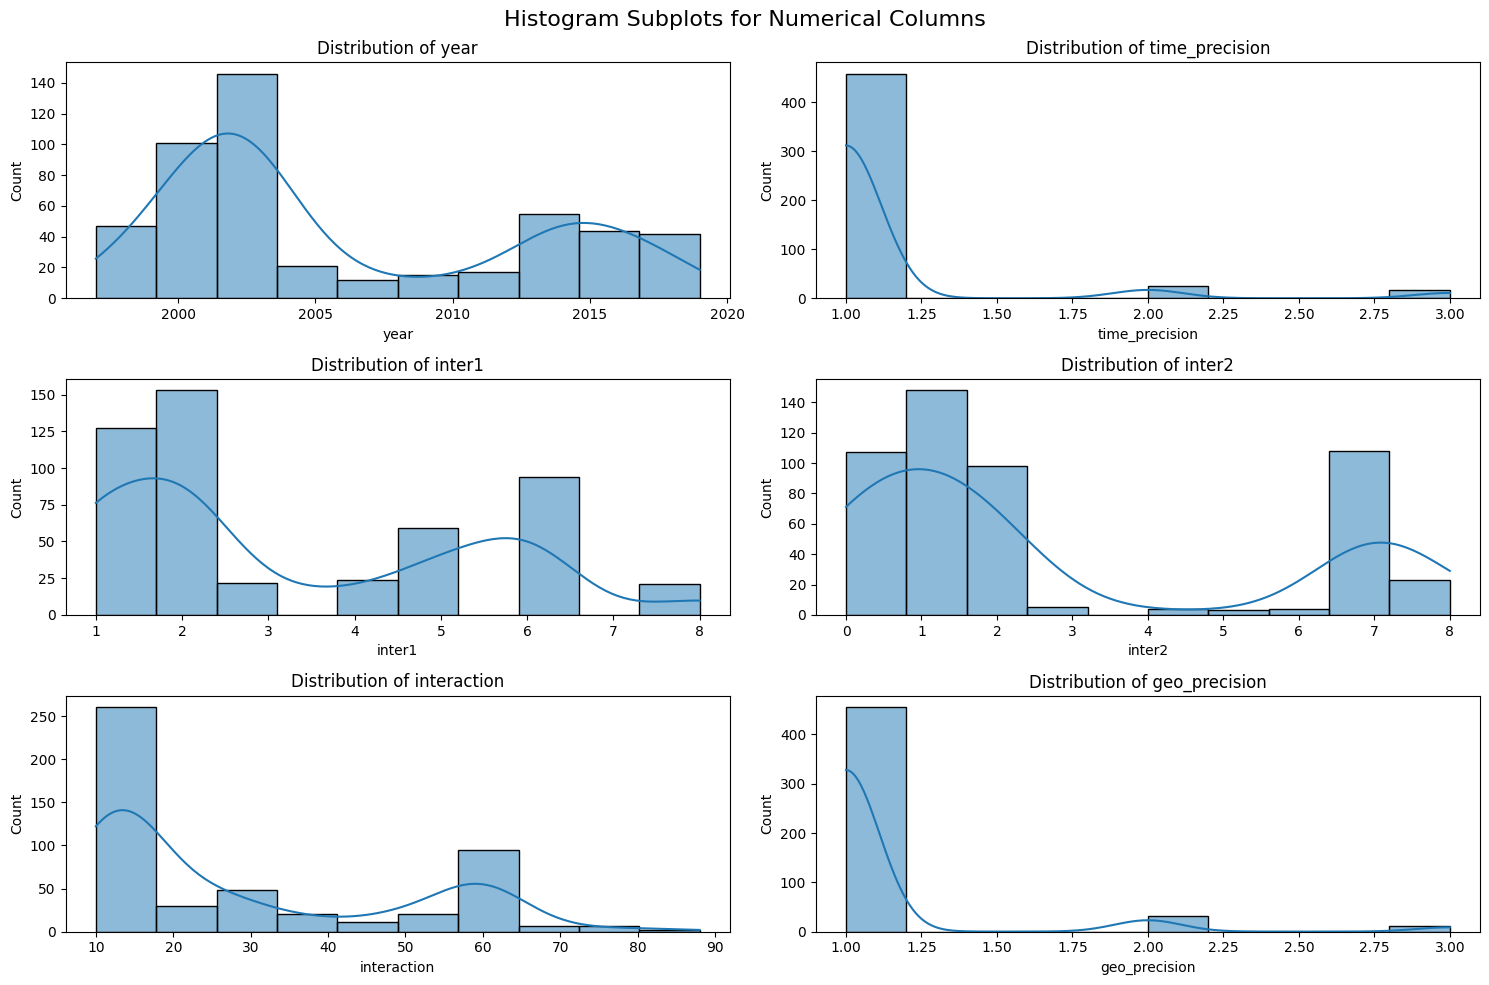

In [10]:
# Select numerical columns for histogram subplots
numerical_columns = ['year', 'time_precision', 'inter1',
                     'inter2', 'interaction', 'geo_precision']

# Sample a subset of rows for better visualization
sampled_df = df.sample(min(500, len(df)))

# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.suptitle('Histogram Subplots for Numerical Columns', fontsize=16)

# Flatten the 3x3 array of subplots for easier indexing
axes = axes.flatten()

# Plot histograms for each numerical column
for i, column in enumerate(numerical_columns):
    sns.histplot(sampled_df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


###### f. Identify and Visualize Outliers in Numerical Columns:

In [11]:
# Create subplots
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, rows * 5))

# Flatten the axes to handle 1D indexing
axes = axes.flatten()

# Identify and visualize outliers in numerical columns using box plots
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

# Remove empty subplots
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'rows' is not defined

In [12]:
# Display summary statistics for numerical columns
summary_stats = df.describe()

# Display summary statistics for object columns
summary_stats_object = df.describe(include=['object']).T

print("Summary Statistics (Numerical Columns):")
summary_stats


Summary Statistics (Numerical Columns):


,data_id,event_id_no_cnty,year,time_precision,inter1,inter2,interaction,geo_precision,timestamp
count,1.318000e+03,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1.318000e+03
mean,2.908782e+06,691.848255,2006.563733,1.136571,3.188164,2.655539,28.569044,1.127466,1.548643e+09
std,5.505368e+04,394.966448,6.489062,0.431678,2.079538,2.764293,19.942195,0.412951,5.040664e+05
min,2.771440e+06,1.000000,1997.000000,1.000000,1.000000,0.000000,10.000000,1.000000,1.548449e+09
25%,2.881066e+06,354.250000,2001.000000,1.000000,1.000000,1.000000,12.000000,1.000000,1.548449e+09
50%,2.915820e+06,685.500000,2003.000000,1.000000,2.000000,1.000000,17.000000,1.000000,1.548449e+09
75%,2.924440e+06,1037.750000,2014.000000,1.000000,5.000000,6.000000,50.000000,1.000000,1.548449e+09
max,3.026337e+06,1376.000000,2019.000000,3.000000,8.000000,8.000000,88.000000,3.000000,1.550172e+09


<ipython-input-13-c45538b9ba2a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


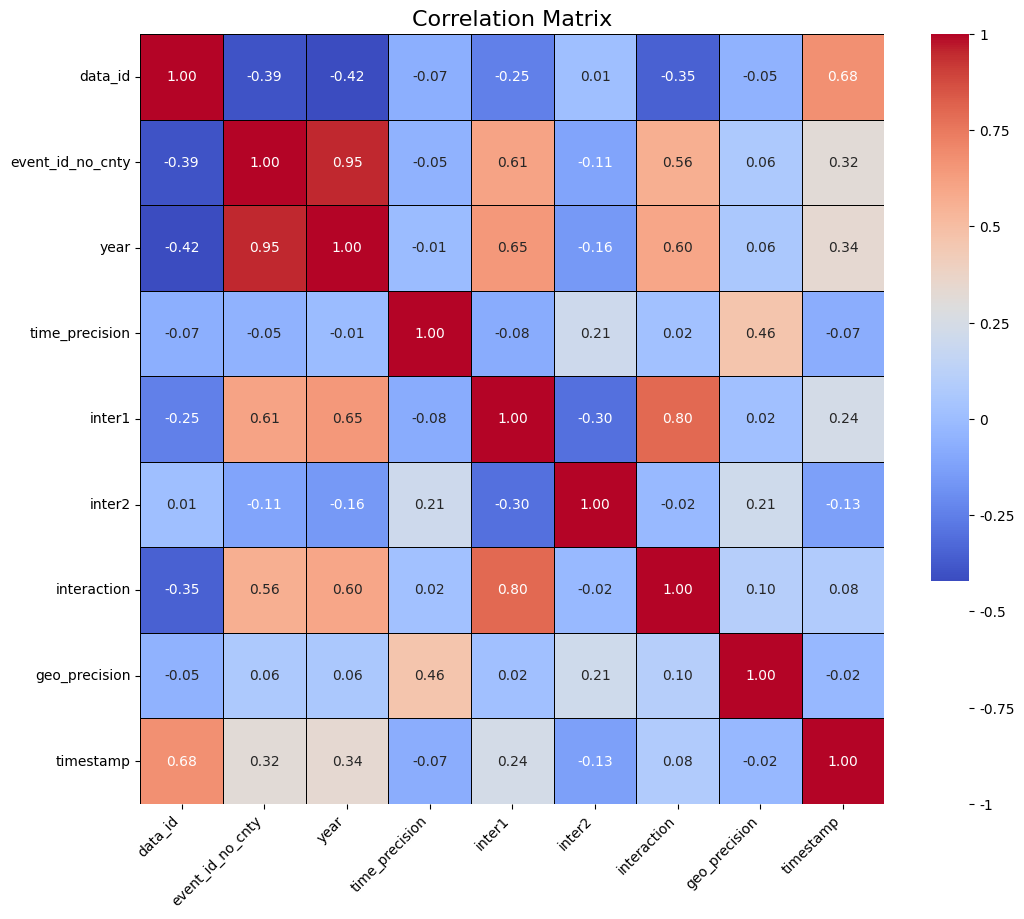

In [13]:
# Display the correlation matrix for numerical columns with an expanded figure
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', fmt=".2f")

# Customize the appearance of the heatmap
heatmap.set_title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')

# Add a color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['-1', '-0.75', '-0.5', '-0.25', '0', '0.25', '0.5', '0.75', '1'])

plt.show()


# QUESTIONS
## PART 1


### 2. What issues or challenges are you experiencing with your dataset if any?




###### Issues and Challenges with the Dataset:

  - Data Type Inconsistencies:
    
    The dataset contains inconsistencies in data types. For example, some date columns are not in the standard date format. This inconsistency can impact the ability to perform accurate date-based analyses. So i need to convert date columns to a standardized format to facilitate accurate temporal analysis.

    - Categorical Column Over-Categorization:
    
    Several categorical columns have a high number of categories, making them challenging to work with. This may lead to difficulties in visualizing and interpreting the data effectively. I might need to   consolidate or groupe them to simplify analyses and visualizations.

    - Missing Values:
        
    There are missing values in several columns, with assoc_actor_1, actor2, assoc_actor_2, and notes being the most affected. Addressing these missing values is crucial for a more comprehensive and accurate analysis. I might need to look at their distribution. That will give me an understanding of whether or not to replace them with mean mode or median depending on the skewness of the distribution. Otherwise i will have to use imputational algorithms to fill missing values.. so the challenge is getting a clear idea on how and which method to use for filling

    - Large Number of Columns:
        
    The dataset comprises 30 columns, including some with NaN values, which may lead to challenges in managing and analyzing the data efficiently. Streamlining the dataset by focusing on relevant columns can enhance analysis.

    - Data Quality and Consistency:
  
    Inconsistencies in data quality, such as missing information in certain columns, will affect the reliability of analyses. Ensuring data consistency is essential for drawing accurate insights since a lot of white space handling and casing is required for some the object columns

    - Column Naming and Documentation:
      
    The dataset lacks clear documentation for column names, requiring additional context to understand the meaning of certain features. Improved documentation will enhance the dataset's usability.


  

### 8. Create a function that accepts the raw data after it has been loaded and returns the cleaned-up data.


In [14]:
def clean_up_data(raw_data):
    # Make a copy to avoid modifying the original data
    cleaned_data = raw_data.copy()

    # 1. Standardize Date Formats
    cleaned_data['event_date'] = pd.to_datetime(cleaned_data['event_date'], errors='coerce')
    cleaned_data['year'] = pd.to_datetime(cleaned_data['year'], format='%Y', errors='coerce').dt.year

    # 2. Handle Categorical Columns
    # (Assume we want to keep only top categories and group others as 'Other')
    categorical_columns = ['assoc_actor_1', 'actor2', 'assoc_actor_2']
    for column in categorical_columns:
        top_categories = cleaned_data[column].value_counts().index[:8]
        cleaned_data[column] = cleaned_data[column].apply(lambda x: x if x in top_categories else 'Other')

    # 4. Address Missing Values
    # For simplicity, let's fill missing values with the median for numerical columns
    numerical_columns = cleaned_data.select_dtypes(include='number').columns
    cleaned_data[numerical_columns] = cleaned_data[numerical_columns].fillna(cleaned_data[numerical_columns].median())

    return cleaned_data

# Usage example
# Assuming 'raw_data' is the loaded raw data
cleaned_data = clean_up_data(df)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 1 to 1318
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data_id           1318 non-null   float64       
 1   iso               1318 non-null   object        
 2   event_id_cnty     1318 non-null   object        
 3   event_id_no_cnty  1318 non-null   float64       
 4   event_date        1318 non-null   datetime64[ns]
 5   year              1318 non-null   int64         
 6   time_precision    1318 non-null   float64       
 7   event_type        1318 non-null   object        
 8   actor1            1318 non-null   object        
 9   assoc_actor_1     1318 non-null   object        
 10  inter1            1318 non-null   float64       
 11  actor2            1318 non-null   object        
 12  assoc_actor_2     1318 non-null   object        
 13  inter2            1318 non-null   float64       
 14  interaction       1318 n

### 5. Consider who would be interested in your dataset. Identify at least three organizations or individuals that would be interested in your insights. Why?


  - **Government Agencies and Policymakers in Liberia:**

    The Ministry of Defense and the Ministry of Justice, could be interested in the dataset to understand patterns of conflict and violence. Insights from the data may inform policy decisions related to security, peacekeeping, and conflict resolution.

  - **International NGOs and Humanitarian Organizations:**   

    The United Nations and organizations focused on peacebuilding, may find the dataset valuable. It can aid in assessing the impact of conflicts, identifying areas in need of assistance, and developing strategies for humanitarian interventions.

  - **Academic Researchers:**

    Researchers specialized in political science, international relations, and conflict studies could be interested in the dataset. The data provides an opportunity to conduct detailed analyses on the dynamics of conflicts in Liberia, contributing to academic research and the development of theories related to political violence.

## PART 2

### Explain how two of the issues raised in this video may impact the dataset from your assigned country. (200 words maximum.)


Based on the histogram distributions while understanding the data, they suggests that the data has two distinct peaks or modes, indicating the presence of two underlying patterns or subpopulations within it.
We call this a bimodal distribution:

If events in remote or politically sensitive areas were underrepresented maybe due to challenges in data collection, the bimodal distribution might reflect a stark contrast between well-documented urban events and underreported rural or politically sensitive events. This bias could affect the accuracy of AI predictions related to those specific events, potentially leading to inadequate resource allocation or policy decisions.
  
If there are inconsistencies in recording events, such as inaccuracies in the reported number of fatalities or unclear categorization of conflict types, the distribution may indicate distinct patterns in well-documented events versus those with data quality issues. This could introduce uncertainties in AI-driven analyses and hinder the reliability of insights derived from the dataset.

If actor information is inaccurately recorded, leading to a bimodal distribution, AI models may struggle to capture the exact dynamics between different conflict actors. This could result in biased predictions regarding the involvement and impact of specific groups in various events, affecting the comprehensiveness of AI-driven analyses related to conflict actors in Liberia.